In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'


tract_info = pd.read_csv('data/tract_info.csv')

df_subject = pd.read_csv('data/subject_info.csv')
df_areas = pd.read_csv('data/tract_cross-sectional-areas.csv')
df_func = pd.read_csv('data/system_functional-surface-areas.csv')

system_colors = {
    'ant':'#003a7d',
    'body':'#4ecc8d',
    'post':'#c700ff'
}

cortices = list(set(tract_info.cortex))
systems = list(system_colors.keys())

df = df_areas.copy()
df['age'] = df_subject['age']
df[['ant_mm','body_mm','post_mm']] = df_func[['ant_mm','body_mm','post_mm']]
df = df.dropna()

display(df)

,id,AF-L__Hipp-L_0,AF-L__Hipp-L_1,CG-L__CC__Hipp-L,CG-L__CC-isthmus__POS1-L_0,AF-L__Hipp-L_2,CC__Hipp-R,CG-L__CC__POS2-L,CC__CC-splenium__ProS-R,CG-L__CC__V3A-L,...,CC__V2-R,CC__CC-isthmus__CG-R__Hipp-R,AF-L__Hipp-R_4,IFO-R__ST-OCC-R__AF-L__Hipp-R,AF-L__FX-L__Hipp-L_1,CC__ILF-L__PHA3-L,age,ant_mm,body_mm,post_mm
0,HCD0001305,12.492314,45.948628,30.660106,0.637349,19.315874,4.014349,1.271122,1.694577,0.874725,...,1.347300,0.315052,41.666059,6.953296,13.126395,1.840375,11.916667,256.14548,422.27676,808.23694
3,HCD0022919,8.145933,38.417246,49.448629,0.972176,29.207022,3.494819,0.726577,1.947841,0.597824,...,0.988442,0.322050,42.797630,10.479829,2.328043,1.489937,9.750000,405.00270,541.88690,628.05250
4,HCD0026119,47.245156,49.228183,31.566864,0.984765,13.406142,2.268093,1.408846,1.103316,0.236176,...,1.088180,0.000000,63.691935,9.128708,14.516532,0.143935,15.166667,897.40640,235.50615,258.15283
5,HCD0029630,18.910583,35.862008,28.360636,1.957182,23.951802,4.613003,0.949462,1.606128,0.190845,...,0.152666,0.233721,66.658482,5.008882,16.921338,0.270847,18.416667,369.14197,427.27820,623.78250
6,HCD0031617,13.109362,43.667242,37.036654,1.113447,23.056369,2.428588,1.284650,1.090314,0.632497,...,1.020533,0.534859,50.812406,22.198136,2.779623,1.468580,19.083333,636.76540,288.44785,591.81494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,HCD2978386,5.760724,12.941554,17.122665,0.944236,12.814879,3.854952,0.631824,1.498024,1.165525,...,0.992633,0.942437,22.557615,0.272407,0.388397,1.709457,9.166667,120.51685,432.10270,1088.40370
535,HCD2982579,19.673321,23.038178,28.887326,1.138459,20.916148,1.796392,1.766133,1.027417,0.415696,...,0.642886,0.049749,51.279669,11.141329,8.097025,0.466146,18.750000,1106.01100,122.30182,231.89955
536,HCD2987185,7.963692,28.980848,38.550812,1.627673,18.021602,3.807203,2.101928,1.793933,1.358675,...,1.624296,0.647867,39.495069,5.517050,2.153107,3.150470,14.583333,457.19315,298.15857,812.17920
537,HCD2990073,20.310970,36.525024,26.188280,1.494767,18.840424,5.715446,1.209990,2.415746,0.639721,...,2.129984,1.202670,30.424541,8.439853,2.999365,1.450308,13.583333,269.19410,775.08203,435.16020


In [5]:

models = {}

for cortex in cortices:
    for system in systems:

        tracts = tract_info[(tract_info.cortex == cortex)]['label']

        df_mediation = pd.DataFrame()
        df_mediation['age'] = df['age']
        df_mediation[f'{system}_mm'] = df[f'{system}_mm']
        df_mediation[f'{cortex}_cross-section'] = df[tracts].sum(axis=1)

        stats = pg.mediation_analysis(
            data=df_mediation,
            x='age',
            y=f'{system}_mm',
            m=f'{cortex}_cross-section'
        )
        models[f'{system}_{cortex}'] = stats


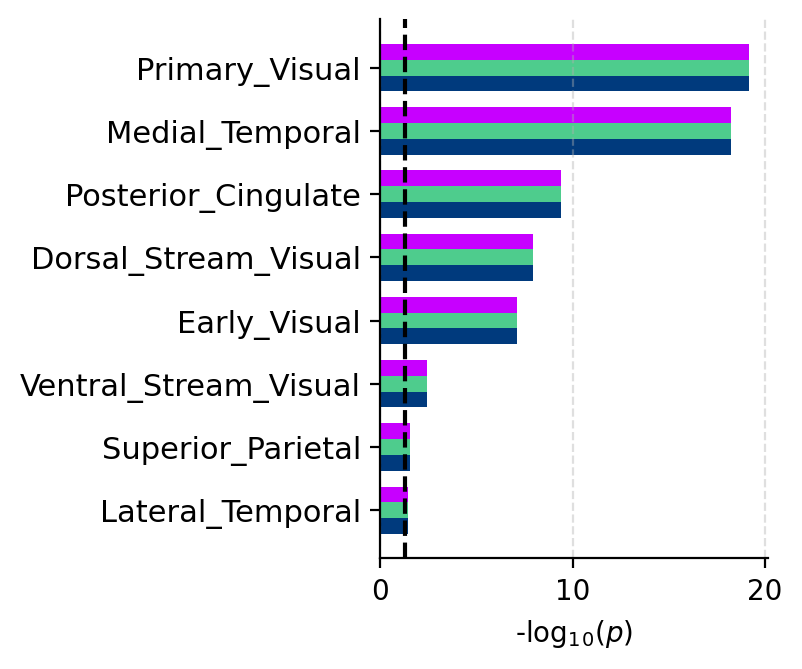

In [10]:

logp = {}
for cortex in cortices:
    for system in systems:

        stats = models[f'{system}_{cortex}']
        p = stats[stats['path'] == f'{cortex}_cross-section ~ X']['pval'].values[0]
        logp[(cortex, system)] = -np.log10(p)


max_logp = {c: max([logp[(c, s)] for s in systems]) for c in cortices}
sorted_cortices = sorted(cortices, key=lambda c: max_logp[c], reverse=False)

n_cortex = len(sorted_cortices)
bar_height = 0.25
y_positions = np.arange(n_cortex)

fig, ax = plt.subplots(figsize=(2.5, 3.5))

for i, system in enumerate(systems):

    vals = [logp[(c, system)] for c in sorted_cortices]
    ax.barh(y_positions + i * bar_height, vals, height=bar_height, color=system_colors[system],)


ax.set_yticks(y_positions + bar_height)
ax.set_yticklabels(sorted_cortices, fontsize=11)
ax.axvline(-np.log10(0.05), color='black', linestyle='--')
ax.set_xlabel('-log$_1$$_0$($p$)')

ax.grid(axis='x', linestyle='--', alpha=0.4)
sns.despine()
plt.show()


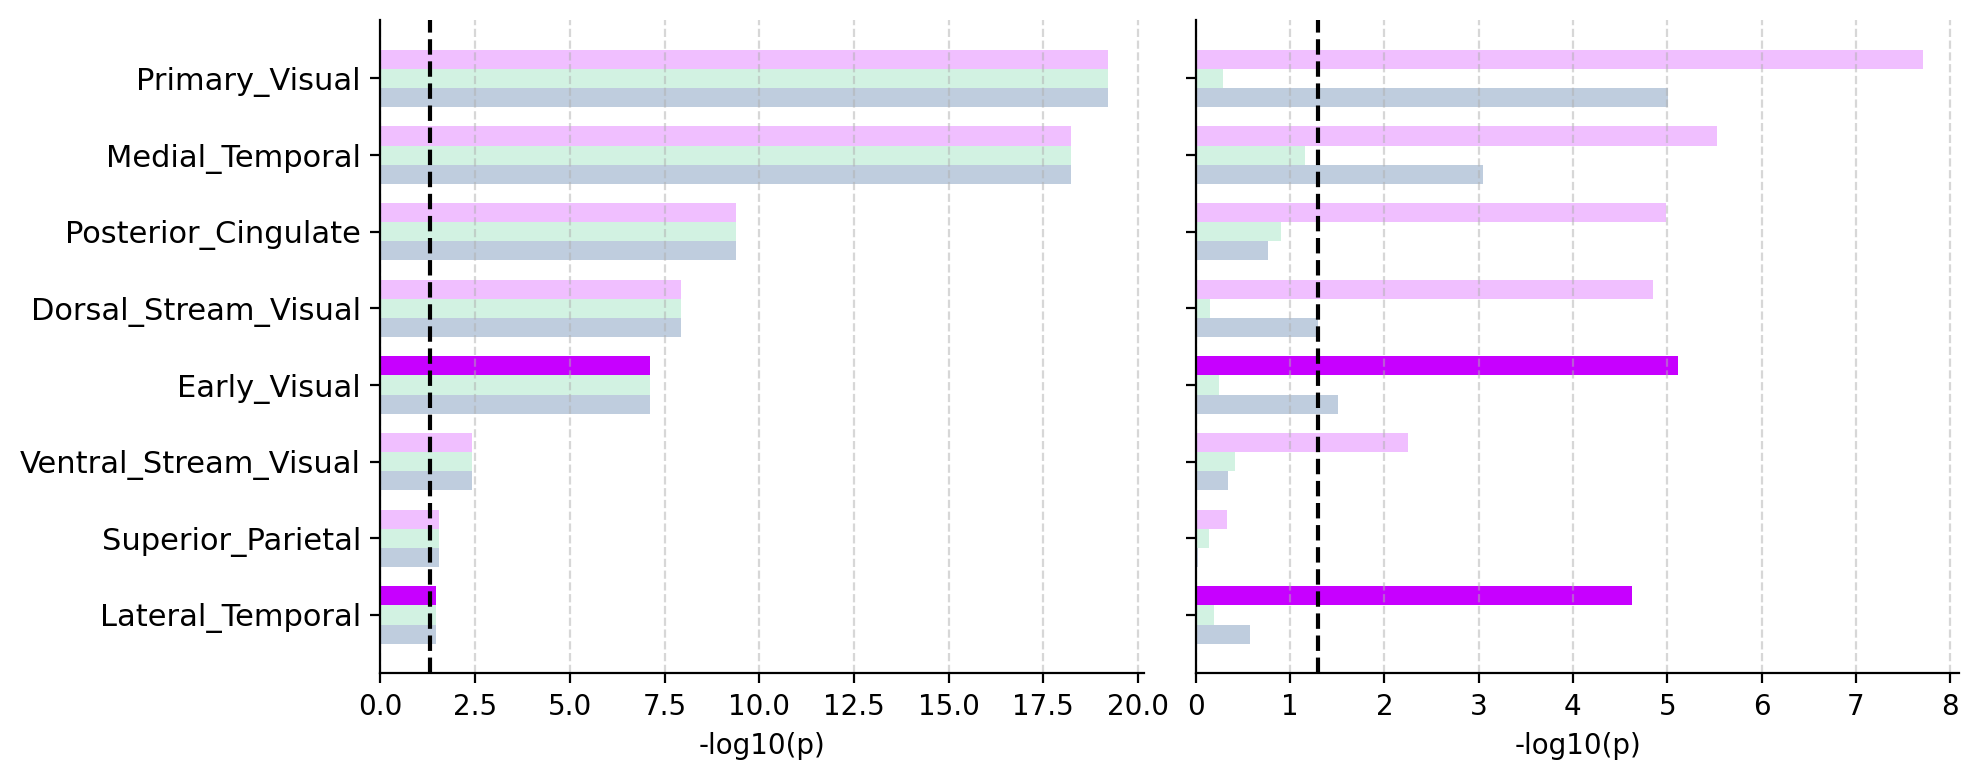

In [27]:
logp_A = {}
logp_B = {}
alphas = {}

for cortex in cortices:
    for system in systems:

        stats = models[f'{system}_{cortex}']

        p_A = stats[stats['path'] == f'{cortex}_cross-section ~ X']['pval'].values[0]
        p_B = stats[stats['path'] == f'Y ~ {cortex}_cross-section']['pval'].values[0]

        p_ind = stats[stats['path'] == 'Indirect']['pval'].values[0]

        logp_A[(cortex, system)] = -np.log10(p_A)
        logp_B[(cortex, system)] = -np.log10(p_B)

        # Joint significance test.
        alphas[(cortex, system)] = 1.0 if ((p_ind <= 0.05) & (p_A <= 0.05) & (p_B <= 0.05)) else 0.25


max_logp_A = {c: max([logp_A[(c, s)] for s in systems]) for c in cortices}
sorted_cortices = sorted(cortices, key=lambda c: max_logp_A[c], reverse=True)
sorted_cortices.reverse()

n_cortex = len(sorted_cortices)
y_pos = np.arange(n_cortex)


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for ax, logp_dict in zip(axes,[logp_A, logp_B]):

    for i, system in enumerate(systems):

        bar_values = [logp_dict[(c, system)] for c in sorted_cortices]
        bar_alphas = [alphas[(c, system)] for c in sorted_cortices]

        for y, val, a in zip(y_pos + i*bar_height, bar_values, bar_alphas):
            ax.barh(
                y, val,
                height=0.25,
                color=system_colors[system],
                alpha=a
            )

    ax.set_yticks(y_pos + bar_height)
    ax.set_yticklabels(sorted_cortices, fontsize=11)
    ax.axvline(-np.log10(0.05), color='black', linestyle='--')
    ax.set_xlabel('-log10(p)')
    ax.grid(axis='x', alpha=.5, linestyle='--')
    sns.despine()

plt.tight_layout()
plt.show()


In [22]:
for model in list(models.keys()):
    print(f'{model}:')
    display(models[model])


ant_Posterior_Cingulate:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Posterior_Cingulate_cross-section ~ X,-0.253944,0.039571,4.011843e-10,-0.331742,-0.176147,Yes
1,Y ~ Posterior_Cingulate_cross-section,-4.153642,3.025984,1.706455e-01,-10.102878,1.795594,No
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,17.193926,2.471581,1.478958e-11,12.334637,22.053215,Yes
4,Indirect,-0.583681,0.750671,3.880000e-01,-2.081654,0.851707,No


body_Posterior_Cingulate:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Posterior_Cingulate_cross-section ~ X,-0.253944,0.039571,4.011843e-10,-0.331742,-0.176147,Yes
1,Y ~ Posterior_Cingulate_cross-section,-4.069186,2.644921,1.247375e-01,-9.269231,1.130860,No
2,Total,1.839387,2.180392,3.994067e-01,-2.447372,6.126146,No
3,Direct,0.890941,2.290008,6.974471e-01,-3.611364,5.393246,No
4,Indirect,0.948446,0.739196,1.760000e-01,-0.380187,2.476579,No


post_Posterior_Cingulate:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Posterior_Cingulate_cross-section ~ X,-0.253944,0.039571,4.011843e-10,-0.331742,-0.176147,Yes
1,Y ~ Posterior_Cingulate_cross-section,11.940722,2.670501,1.019935e-05,6.690384,17.191060,Yes
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-21.113872,2.050627,3.745700e-22,-25.145540,-17.082204,Yes
4,Indirect,-1.020258,0.614137,9.200000e-02,-2.377941,-0.020468,No


ant_Primary_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Primary_Visual_cross-section ~ X,-0.269569,0.027917,6.310087e-20,-0.324455,-0.214682,Yes
1,Y ~ Primary_Visual_cross-section,-17.741626,3.961457,9.876811e-06,-25.530048,-9.953204,Yes
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,14.648141,2.608350,3.722335e-08,9.519955,19.776327,Yes
4,Indirect,1.962105,1.254301,1.200000e-01,-0.616666,4.424190,No


body_Primary_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Primary_Visual_cross-section ~ X,-0.269569,0.027917,6.310087e-20,-0.324455,-0.214682,Yes
1,Y ~ Primary_Visual_cross-section,2.339019,3.550501,5.104212e-01,-4.641442,9.319479,No
2,Total,1.839387,2.180392,3.994067e-01,-2.447372,6.126146,No
3,Direct,3.058900,2.425508,2.080131e-01,-1.709807,7.827607,No
4,Indirect,-1.219513,1.144703,2.960000e-01,-3.510739,0.776084,No


post_Primary_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Primary_Visual_cross-section ~ X,-0.269569,0.027917,6.310087e-20,-0.324455,-0.214682,Yes
1,Y ~ Primary_Visual_cross-section,20.197479,3.521149,1.942831e-08,13.274725,27.120232,Yes
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-20.669388,2.171260,1.860975e-19,-24.938228,-16.400548,Yes
4,Indirect,-1.464742,0.990709,1.160000e-01,-3.325084,0.383547,No


ant_Medial_Temporal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Medial_Temporal_cross-section ~ X,25.914973,2.765980,5.927055e-19,20.476918,31.353027,Yes
1,Y ~ Medial_Temporal_cross-section,0.135899,0.040652,9.087263e-04,0.055976,0.215822,Yes
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,16.026849,2.602447,1.829797e-09,10.910268,21.143431,Yes
4,Indirect,0.583396,1.216105,6.200000e-01,-1.686500,3.087017,No


body_Medial_Temporal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Medial_Temporal_cross-section ~ X,25.914973,2.765980,5.927055e-19,20.476918,31.353027,Yes
1,Y ~ Medial_Temporal_cross-section,-0.065221,0.035908,7.008109e-02,-0.135817,0.005375,No
2,Total,1.839387,2.180392,3.994067e-01,-2.447372,6.126146,No
3,Direct,4.322004,2.397950,7.225844e-02,-0.392522,9.036529,No
4,Indirect,-2.482617,1.006900,8.000000e-03,-4.555340,-0.745105,Yes


post_Medial_Temporal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Medial_Temporal_cross-section ~ X,25.914973,2.765980,5.927055e-19,20.476918,31.353027,Yes
1,Y ~ Medial_Temporal_cross-section,-0.171536,0.036189,2.997958e-06,-0.242685,-0.100386,Yes
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-21.660012,2.164795,3.952967e-21,-25.916141,-17.403883,Yes
4,Indirect,-0.474118,0.955332,6.080000e-01,-2.297579,1.237881,No


ant_Superior_Parietal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Superior_Parietal_cross-section ~ X,-0.009622,0.004363,2.800787e-02,-0.018200,-0.001044,Yes
1,Y ~ Superior_Parietal_cross-section,-2.362001,28.744621,9.345521e-01,-58.875354,54.151353,No
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,16.793855,2.365734,5.989907e-12,12.142668,21.445041,Yes
4,Indirect,-0.183609,0.263408,3.920000e-01,-0.870958,0.192782,No


body_Superior_Parietal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Superior_Parietal_cross-section ~ X,-0.009622,0.004363,0.028008,-0.018200,-0.001044,Yes
1,Y ~ Superior_Parietal_cross-section,9.159487,25.136175,0.715760,-40.259482,58.578457,No
2,Total,1.839387,2.180392,0.399407,-2.447372,6.126146,No
3,Direct,1.951497,2.196125,0.374761,-2.366228,6.269223,No
4,Indirect,-0.112110,0.283342,0.660000,-0.873515,0.347446,No


post_Superior_Parietal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Superior_Parietal_cross-section ~ X,-0.009622,0.004363,2.800787e-02,-0.018200,-0.001044,Yes
1,Y ~ Superior_Parietal_cross-section,19.136443,25.927997,4.609201e-01,-31.839287,70.112174,No
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-22.223039,1.968676,9.210071e-26,-26.093585,-18.352494,Yes
4,Indirect,0.088909,0.266632,6.400000e-01,-0.414302,0.718162,No


ant_Ventral_Stream_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Ventral_Stream_Visual_cross-section ~ X,-0.059983,0.020582,3.768455e-03,-0.100448,-0.019519,Yes
1,Y ~ Ventral_Stream_Visual_cross-section,-4.517305,6.061431,4.565660e-01,-16.434378,7.399769,No
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,16.694226,2.377870,9.860737e-12,12.019178,21.369274,Yes
4,Indirect,-0.083981,0.383235,8.320000e-01,-0.888179,0.651185,No


body_Ventral_Stream_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Ventral_Stream_Visual_cross-section ~ X,-0.059983,0.020582,0.003768,-0.100448,-0.019519,Yes
1,Y ~ Ventral_Stream_Visual_cross-section,4.586892,5.300055,0.387327,-5.833280,15.007064,No
2,Total,1.839387,2.180392,0.399407,-2.447372,6.126146,No
3,Direct,2.160458,2.203953,0.327563,-2.172657,6.493572,No
4,Indirect,-0.321071,0.339147,0.356000,-1.132829,0.251028,No


post_Ventral_Stream_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Ventral_Stream_Visual_cross-section ~ X,-0.059983,0.020582,3.768455e-03,-0.100448,-0.019519,Yes
1,Y ~ Ventral_Stream_Visual_cross-section,15.111734,5.421529,5.573239e-03,4.452738,25.770730,Yes
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-21.688815,1.972048,1.091162e-24,-25.565990,-17.811640,Yes
4,Indirect,-0.445315,0.316691,1.000000e-01,-1.152865,0.092860,No


ant_Dorsal_Stream_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Dorsal_Stream_Visual_cross-section ~ X,-0.200534,0.034394,1.157808e-08,-0.268154,-0.132914,Yes
1,Y ~ Dorsal_Stream_Visual_cross-section,-6.865610,3.502038,5.065158e-02,-13.750791,0.019572,No
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,16.557916,2.452758,5.347113e-11,11.735635,21.380198,Yes
4,Indirect,0.052329,0.695635,8.960000e-01,-1.381687,1.518293,No


body_Dorsal_Stream_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Dorsal_Stream_Visual_cross-section ~ X,-0.200534,0.034394,1.157808e-08,-0.268154,-0.132914,Yes
1,Y ~ Dorsal_Stream_Visual_cross-section,-1.166851,3.077356,7.047649e-01,-7.217086,4.883383,No
2,Total,1.839387,2.180392,3.994067e-01,-2.447372,6.126146,No
3,Direct,1.744973,2.276053,4.437438e-01,-2.729896,6.219841,No
4,Indirect,0.094414,0.627082,9.480000e-01,-0.998052,1.474397,No


post_Dorsal_Stream_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Dorsal_Stream_Visual_cross-section ~ X,-0.200534,0.034394,1.157808e-08,-0.268154,-0.132914,Yes
1,Y ~ Dorsal_Stream_Visual_cross-section,13.626828,3.100898,1.432247e-05,7.530308,19.723347,Yes
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-21.088331,2.031651,1.888998e-22,-25.082690,-17.093972,Yes
4,Indirect,-1.045799,0.651871,1.040000e-01,-2.809068,0.020931,No


ant_Early_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Early_Visual_cross-section ~ X,-0.282353,0.051559,7.786337e-08,-0.383721,-0.180985,Yes
1,Y ~ Early_Visual_cross-section,-5.072303,2.344718,3.112426e-02,-9.682136,-0.462471,Yes
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,16.342221,2.440660,7.496286e-11,11.543724,21.140717,Yes
4,Indirect,0.268025,0.649121,6.640000e-01,-0.895773,1.822088,No


body_Early_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Early_Visual_cross-section ~ X,-0.282353,0.051559,7.786337e-08,-0.383721,-0.180985,Yes
1,Y ~ Early_Visual_cross-section,1.166097,2.062098,5.720645e-01,-2.888090,5.220284,No
2,Total,1.839387,2.180392,3.994067e-01,-2.447372,6.126146,No
3,Direct,2.334973,2.263412,3.028913e-01,-2.115043,6.784988,No
4,Indirect,-0.495586,0.601033,4.560000e-01,-1.631169,0.660480,No


post_Early_Visual:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Early_Visual_cross-section ~ X,-0.282353,0.051559,7.786337e-08,-0.383721,-0.180985,Yes
1,Y ~ Early_Visual_cross-section,9.412006,2.075157,7.651904e-06,5.332144,13.491868,Yes
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-20.970475,2.018587,1.757450e-22,-24.939149,-17.001802,Yes
4,Indirect,-1.163655,0.600373,2.800000e-02,-2.686181,-0.235520,Yes


ant_Lateral_Temporal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Lateral_Temporal_cross-section ~ X,-0.062485,0.029514,3.488328e-02,-0.120511,-0.004458,Yes
1,Y ~ Lateral_Temporal_cross-section,-4.755973,4.244474,2.631844e-01,-13.100819,3.588873,No
2,Total,16.610245,2.349622,7.206170e-12,11.990771,21.229720,Yes
3,Direct,16.500068,2.365498,1.314567e-11,11.849344,21.150793,Yes
4,Indirect,0.110177,0.271559,6.480000e-01,-0.326901,0.776468,No


body_Lateral_Temporal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Lateral_Temporal_cross-section ~ X,-0.062485,0.029514,0.034883,-0.120511,-0.004458,Yes
1,Y ~ Lateral_Temporal_cross-section,1.724521,3.717176,0.642954,-5.583631,9.032673,No
2,Total,1.839387,2.180392,0.399407,-2.447372,6.126146,No
3,Direct,1.969463,2.194791,0.370094,-2.345640,6.284566,No
4,Indirect,-0.130076,0.229184,0.572000,-0.705503,0.217933,No


post_Lateral_Temporal:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Lateral_Temporal_cross-section ~ X,-0.062485,0.029514,3.488328e-02,-0.120511,-0.004458,Yes
1,Y ~ Lateral_Temporal_cross-section,16.043231,3.750593,2.378681e-05,8.669379,23.417084,Yes
2,Total,-22.134130,1.954457,6.601197e-26,-25.976689,-18.291571,Yes
3,Direct,-21.373910,1.934642,7.151070e-25,-25.177543,-17.570278,Yes
4,Indirect,-0.760220,0.424292,3.200000e-02,-1.985199,-0.208775,Yes
